In [1]:
# Install tensorboard
import os

import torch.optim
!pip install tensorboard


if not os.path.exists('logs'):
    os.makedirs('logs')


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
from dataload import *
from lin_reg import *
from neural_net import *
import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
dataset = dense_Dataset('data/embeddings.h5', 'data/densities.csv', test_perc=0.50, val_perc=0.15) 

In [80]:
h_params = {
    'input_size': 1024,
    'n_hidden': 512, 
    'batch_size': 128,
    'epochs':20,
    'lr': .01
}

In [81]:
# Linear regression model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

linear_regression = Lin_reg(h_params)

linear_regression = linear_regression.to(device)

In [82]:
# Neural network model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
neural_net = NeuralNet(h_params)
neural_net = neural_net.to(device)

In [ ]:
# for tensorboard
path = "logs/protpred1"
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')

tb_logger = SummaryWriter(path)
# tb_logger.add_graph(linear_regression, torch.randn(1, 1024))

# actual training
model = neural_net

batch_size = h_params['batch_size']
epochs = h_params['epochs']
best_model = None
best_val_loss = float('inf')

losses_train = []
losses_val = []
print('starting cross validation')

train_keys, val_keys = dataset.train_keys, dataset.val_keys
print(f"Train keys: {len(train_keys)}, Val keys: {len(val_keys)}")

train_loader = Dataloader(dataset, train_keys, batch_size=batch_size, shuffle=True)
val_loader = Dataloader(dataset, val_keys, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=model.hparams['lr'])
# optimizer = torch.optim.Adam(model.parameters(), lr=model.hparams['lr'])
criterion = nn.MSELoss()

for epoch in range(epochs):
    model.train()  # training model
    running_loss = 0.0

    for inputs, targets in tqdm.tqdm(train_loader, maxinterval=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}'):
        # send data to device
        inputs, targets = inputs.to(model.device), targets.to(model.device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses_train.append(running_loss / len(train_loader))
    tb_logger.add_scalar('Training loss', running_loss / len(train_loader), epoch)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_running_loss = 0.0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(model.device), targets.to(model.device)
            outputs = model(inputs)
            outputs = outputs.view(-1)
            val_loss += criterion(outputs, targets).item()

            val_running_loss += val_loss

    # remember validation scores
    losses_val.append(val_running_loss / len(val_loader))
    tb_logger.add_scalar('Validation loss', val_running_loss / len(val_loader), epoch)

    avg_val_loss = val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model

print(f"Best validation loss: {best_val_loss}")

starting cross validation
Train keys: 7666, Val keys: 1353


Epoch 1/20:   5%|▌         | 3/60 [00:16<05:02,  5.31s/it]

In [ ]:
# save the model checkpoint
torch.save(best_model.state_dict(), 'models/neural_net.pth')

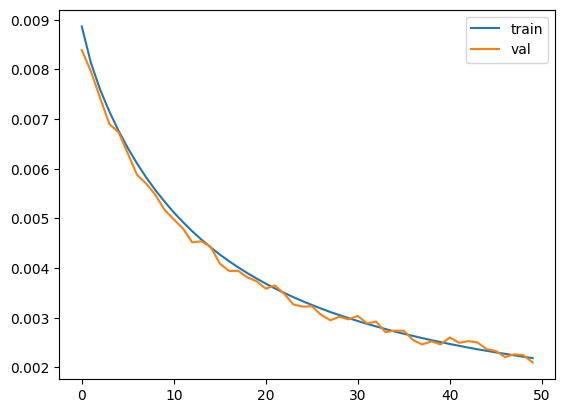

In [10]:
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()

In [6]:
# load a saved model
model = Lin_reg(hparams=h_params)
model.load_state_dict(torch.load('models/lin_reg_model.pth'))
model.to(device)

Lin_reg(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
def predict(dataset, keys, model):
    batch_size = 32

    test_loader = Dataloader(dataset, keys, batch_size=batch_size, shuffle=False)
    model.eval()
    predictions = []
    truths = []
    with torch.no_grad():
        for inputs, targets in tqdm.tqdm(test_loader, maxinterval=len(test_loader)):
            inputs = inputs.to(model.device)
            outputs = model(inputs)
            predictions.append(outputs)
            truths.append(targets)

    return predictions, truths


In [9]:
# predict on training and validation set
train_preds, train_truths = predict(dataset, dataset.train_keys, model)
val_preds, val_truths = predict(dataset, dataset.val_keys, model)

# calculate R2 score, Pearson correlation and MSE
train_r2, train_pearson, train_mse = evaluate(train_preds, train_truths)
val_r2, val_pearson, val_mse = evaluate(val_preds, val_truths)
print(f"Train R2: {train_r2}, Train Pearson: {train_pearson}, Train MSE: {train_mse}")
print(f"Val R2: {val_r2}, Val Pearson: {val_pearson}, Val MSE: {val_mse}")


100%|██████████| 71/71 [01:38<00:00,  1.39s/it]


Train R2: -0.2538379430770874, Train Pearson: PearsonRResult(statistic=0.09436126703913501, pvalue=0.0), Train MSE: 0.002171992789953947
Val R2: -0.2460421323776245, Val Pearson: PearsonRResult(statistic=0.09208420064283342, pvalue=0.0), Val MSE: 0.0021470123901963234


In [8]:
# save train preds and train truths to pickle
import pickle
predictions = {'train_preds': train_preds, 'train_truths': train_truths, 'val_preds': val_preds, 'val_truths': val_truths}
with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [13]:
# save losses to csv
import pandas as pd
losses = pd.DataFrame({'train': losses_train, 'val': losses_val})
losses.to_csv('losses.csv', index=False)